In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

### Explanation of DoubleConv, Down, Up, OutConv, and UNet Classes

These classes form the basic components of the U-Net architecture, which is used for removing watermarks from images. Each class's function is explained below:

**DoubleConv Class**:
This class is a module consisting of two consecutive convolutional layers. The first layer applies convolution using the number of channels from the input and then applies Batch Normalization and ReLU activation function. The same process is repeated for the second convolutional layer. This module extracts features from the image and enriches the feature map.

**Down Class**:
This class is a downscaling module that combines max pooling with a double convolution. First, the max pooling layer halves the input size, and then the double convolutional layer extracts features. This module reduces the size of the input image while preserving important features.

**Up Class**:
This class is an upscaling module that combines a transpose convolution with a double convolution. The transpose convolution layer doubles the input size, and then the double convolutional layer extracts features. This module reconstructs higher resolution feature maps and concatenates them with features from previous layers.

**OutConv Class**:
This class is the final convolutional layer that maps the features to the desired number of classes. This layer converts the output feature map to the final image.

**UNet Class**:
This class uses the U-Net architecture to remove watermarks from images. U-Net is an encoder-decoder structure that reduces the input image to various feature levels and then reconstructs these features at higher resolution. This structure ensures that important features are preserved at each stage and produces high-quality output images. The model takes input images and processes them through double convolution, downscaling, and upscaling modules, ultimately providing watermark-free output images.

In [2]:
class DoubleConv(nn.Module):
    """
    A module consisting of two consecutive convolutional layers.
    """
    def __init__(self, in_channels, out_channels):
        """
        @param in_channels Number of channels in the input.
        @param out_channels Number of channels in the output of the second convolution.
        @param mid_channels Optional; Number of channels in the output of the first convolution and input of the second.
        """
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        """
        Forward pass of the DoubleConv module.

        @param x: Tensor.
        """
        return self.double_conv(x)

class Down(nn.Module):
    """
    A downscaling module combining max pooling with a double convolution.
    """
    def __init__(self, in_channels, out_channels):
        """
        @param in_channels: Number of input channels.
        @param out_channels: Number of output channels for the double convolution.
        """
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        """
        Forward pass of the Down module.

        @param x: Tensor.
        """
        return self.maxpool_conv(x)

class Up(nn.Module):
    """
    An upscaling module combining a transpose convolution with a double convolution.
    """
    def __init__(self, in_channels, out_channels):
        """
        @param in_channels: Number of input channels.
        @param out_channels: Number of output channels for the double convolution.
        @param bilinear Boolean; Use bilinear upsampling instead of transposed convolution if True.
        """
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        """
        Forward pass of the Up module.

        @param x1: Tensor; Output from the lower layer.
        @param x2: Tensor; Corresponding encoder feature for concatenation.
        """
        x1 = self.up(x1)

        # Calculate the difference in height and width between the tensors x2 and x1
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        # Pad x1 to match the size of x2
        # F.pad(x1, [left, right, top, bottom]) pads the input tensor x1
        # so that its size matches x2's size in height and width dimensions.
        # This ensures that x1 and x2 can be concatenated along the channel dimension.
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """
    The final convolution that maps the features to the desired number of classes.
    """
    def __init__(self, in_channels, out_channels):
        """
        @param in_channels: Number of input channels.
        @param out_channels: Number of output channels.
        """
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        """
        Forward pass of the OutConv module.

        @param x: Tensor.
        """
        return self.conv(x)
    
class UNet(nn.Module):
    """
    U-Net architecture to remove watermarks from images.
    """
    def __init__(self, n_channels=3, n_classes=3):
        """
        @param n_channels: Number of channels in the input images.
        @param n_classes: Number of channels in the output images.
        """
        super(UNet, self).__init__()

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        self.down4 = (Down(512, 1024))
        self.up1 = (Up(1024, 512))
        self.up2 = (Up(512, 256))
        self.up3 = (Up(256, 128))
        self.up4 = (Up(128, 64))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        """
        Forward pass of the entire U-Net model.

        @param x Tensor; Input image or batch of images.
        """
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

### Explanation of load_model Function
The `load_model` function loads a pre-trained UNet model from a specified file path. It first initializes a new instance of the UNet model. Then, it loads the saved state dictionary (containing the model's weights and biases) from the given file path using `torch.load()`. The state dictionary is loaded into the UNet model using the `load_state_dict()` method. Finally, the model is set to evaluation mode by calling `model.eval()`, which configures the model for inference (disabling dropout and batch normalization layers). The function returns the loaded UNet model, ready for use in evaluation or prediction tasks.

In [3]:
def load_model(model_path):
    """
    Loads a pre-trained UNet model from the specified file path.

    Parameters:
    model_path (str): The path to the file containing the saved model state.

    Returns:
    model (torch.nn.Module): The loaded UNet model set to evaluation mode.
    """
    # Initialize a new UNet model
    model = UNet()
    
    # Load the saved model state dictionary from the specified file path
    state_dict = torch.load(model_path)
    
    # Load the state dictionary into the model
    model.load_state_dict(state_dict)
    
    # Set the model to evaluation mode
    model.eval()
    
    return model

### Explanation of unnormalize Function
The `unnormalize` function reverses the normalization of an image by adding the mean values back to each channel. It takes two parameters: image, a normalized image tensor of shape (3, H, W), where 3 represents the color channels (e.g., RGB), and `mean_values`, a list or tuple containing the mean values used for normalization for each channel. The function iterates over the three channels and adds the corresponding mean value back to each channel. This process restores the original pixel values, effectively undoing the normalization. The function returns the unnormalized image tensor.

In [4]:
def unnormalize(image, mean_values):
    """
    Unnormalizes an image by adding the mean values back to each channel.

    Parameters:
    image (torch.Tensor): The normalized image tensor of shape (3, H, W).
    mean_values (list or tuple): The mean values used for normalization for each channel.

    Returns:
    torch.Tensor: The unnormalized image tensor.
    """
    # Iterate over each of the 3 channels (assuming image has shape (3, H, W))
    for i in range(3):
        # Add the mean value back to each channel
        image[i, :, :] += mean_values[i]
    return image

### Explanation of predict_and_process FunctionThe `predict_and_process` function performs prediction on a processed image using a pre-trained model and processes the prediction output. It takes three parameters: `model`, the pre-trained model used for prediction; `processed_image`, a tensor representing the processed image; and `mean_values`, a list or tuple of mean values used for normalization (though it is not used directly in this function).

The function starts by ensuring that no gradients are computed during the prediction by using the `torch.no_grad()` context manager. This reduces memory consumption and speeds up computation. It then makes a prediction by passing the `processed_image` through the model.

After obtaining the prediction, the function removes the batch dimension (which is typically the first dimension of the tensor) using `squeeze(0)` and converts the resulting tensor to a NumPy array using `cpu().numpy()`. The function returns this processed prediction array, which can then be used for further analysis or visualization..

In [5]:
def predict_and_process(model, processed_image, mean_values):
    """
    Makes a prediction using the given model on the processed image and processes the prediction.

    Parameters:
    model (torch.nn.Module): The pre-trained model used for making predictions.
    processed_image (torch.Tensor): The processed image tensor to be used for prediction.
    mean_values (list or tuple): The mean values used for normalization, not used directly in this function.

    Returns:
    np.ndarray: The processed prediction array.
    """
    # Ensure no gradients are computed during prediction
    with torch.no_grad():
        # Make a prediction using the model
        prediction = model(processed_image)
    
    # Remove the batch dimension and convert the prediction to a NumPy array
    prediction = prediction.squeeze(0).cpu().numpy()
    
    return prediction


### Explanation of visualize_model_outputs Function
The `visualize_model_outputs` function visualizes the outputs of a pre-trained model on a specified image. It starts by defining the paths to the model file and the specific image to be processed. The image is resized to `128x128 pixels` for consistency. The function loads the pre-trained model using the `load_model` function, which initializes the UNet model, loads its state dictionary, and sets it to evaluation mode.

A helper function `zero_mean_normalize` is defined to normalize the image tensor by subtracting its mean, updating a global_mean variable that stores this mean. This normalization ensures the model processes the image correctly.

The function applies a transformation pipeline to the image, converting it to a tensor and normalizing it. The processed tensor is then fed into the model to obtain a prediction. The prediction tensor is processed to remove the batch dimension and converted to a NumPy array for visualization.

The `global_mean` is adjusted and added back to the prediction image to restore the original mean values. The function then visualizes and saves the watermarked image, the model's output, and the original image to specified files.

This function helps in visualizing the effectiveness of the model's predictions and comparing them with the original and watermarked images.

In [6]:
def visualize_model_outputs(model_name, image_dir, image_number):
    """
    Visualizes the outputs of a model on a given image.

    Parameters:
    model_name (str): The name of the model.
    image_dir (str): The directory containing the images.
    image_number (int): The number of the image to visualize.

    Returns:
    None
    """
    model_path = f'{model_name}.pt'  # Path to the model file
    image_path = f'{image_dir}/frame_{image_number}_watermarked.jpg'  # Path to the specific image file
    N = 128  # Size to which the image will be resized

    model = load_model(model_path)  # Load the model
    
    global_mean = 0  # Initialize global mean
    
    def zero_mean_normalize(tensor):
        """
        Normalizes the tensor by subtracting its mean.

        Parameters:
        tensor (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The normalized tensor.
        """
        nonlocal global_mean
        mean = tensor.mean([1, 2], keepdim=True)  # Calculate the mean of the tensor
        global_mean = mean  # Update global mean
        return tensor - mean  # Subtract the mean from the tensor
    
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to tensor
        zero_mean_normalize  # Normalize the tensor
    ])
    
    # Process the image and convert to tensor
    processed_tensor = transform(Image.open(image_path).convert('RGB').resize((N, N)))
    
    # Get model prediction
    prediction = model(processed_tensor.unsqueeze(0))
    prediction_image = prediction.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()  # Process prediction for visualization
    
    # Adjust global mean for the prediction image
    global_mean_adjusted = np.tile(global_mean.numpy().squeeze(), (prediction_image.shape[0], prediction_image.shape[1], 1))
    
    # Add global mean back to the prediction image
    prediction_image += global_mean_adjusted
    
    # Visualize and save the watermarked image
    plt.title("Watermarked Image")
    image = Image.open(image_path).convert('RGB').resize((N, N))
    plt.imshow(image)
    plt.show()
    image.save(f'visualizator_outputs/{model_name}Watermarked.jpg')
    
    # Visualize and save the model output image
    prediction_image = (prediction_image * 255).astype('uint8')
    plt.imshow(prediction_image)
    plt.title("Model Output")
    plt.show()
    image = Image.fromarray(prediction_image.astype('uint8'))
    image.save(f'visualizator_outputs/{model_name}ModelOutput.jpg')
    
    # Visualize and save the original image
    plt.title("Original Image")
    image = Image.open(f'{image_dir}/frame_{image_number}.jpg').convert('RGB').resize((N, N))
    plt.imshow(image)
    plt.show()
    image.save(f'visualizator_outputs/{model_name}Original.jpg')

## Example Visualization of No Logo Low Opacity U-Net Model From Test Dataset

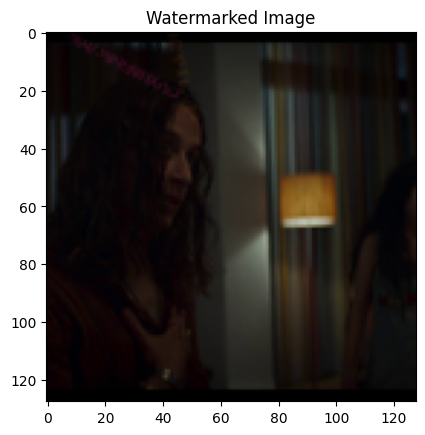

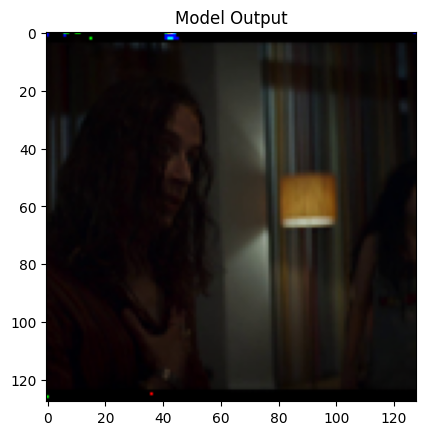

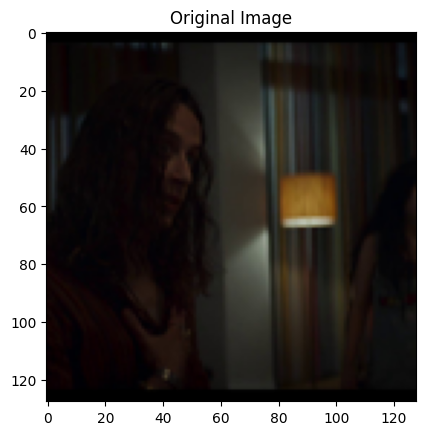

In [7]:
visualize_model_outputs('modelNoLogoLOpacity', 'no_logo_and_low_opacity_watermark_dataset_test', 3095)

## Example Visualization of No Logo High Opacity U-Net Model From Test Dataset

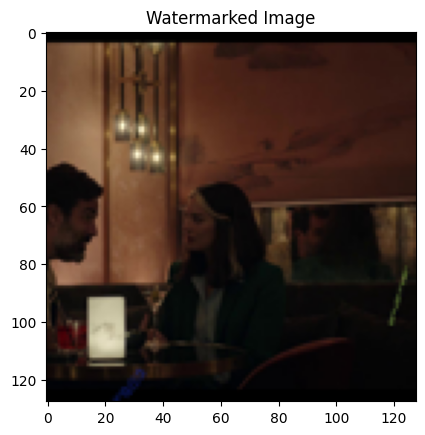

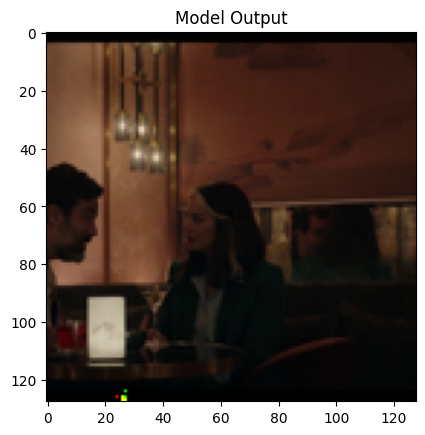

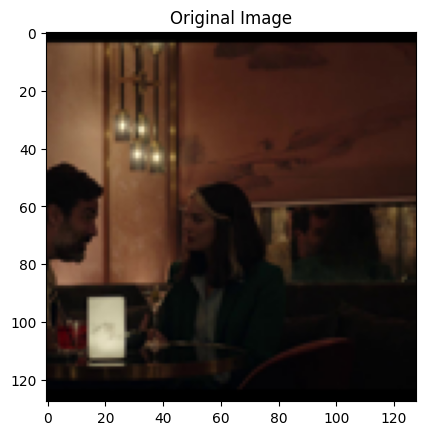

In [8]:
visualize_model_outputs('modelNoLogoHOpacity', 'no_logo_and_high_opacity_watermark_dataset_test', 238)

## Example Visualization of Logo High Opacity U-Net Model From Test Dataset

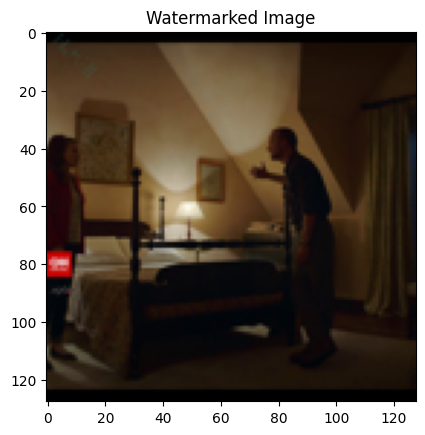

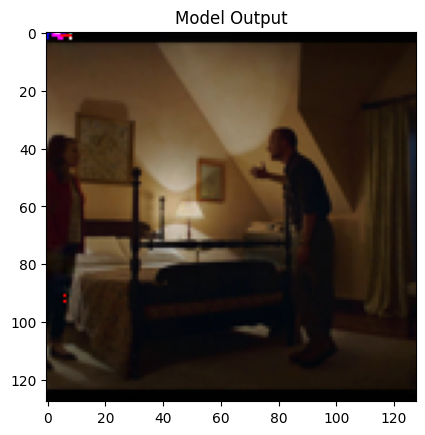

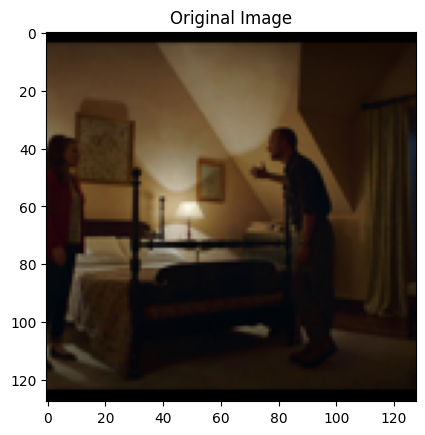

In [9]:
visualize_model_outputs('modelLogoHOpacity', 'logo_and_high_opacity_watermark_dataset_test', 4119)